In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy

2025-11-03 19:00:45.911154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-03 19:00:46.507612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Enable mixed precision training to optimize GPU memory usage
set_global_policy('mixed_float16')

In [3]:
# Define Paths
data_path = '../data/ISIC_2019_Training_Input'
csv_path = '../data/ISIC_2019_Training_GroundTruth.csv'

In [4]:
# Load metadata
df = pd.read_csv(csv_path)

In [5]:
# Add image paths to DataFrame for easy access
df['image_path'] = df['image'].apply(lambda x: os.path.join(data_path, x + '.jpg'))

In [6]:
# Convert one-hot encoded labels to categorical
class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
df['label'] = df[class_columns].idxmax(axis=1)

In [7]:
#  Split data into train (70%), validation (15%) and test (15%) sets
train_df, temp_df = train_test_split(df, test_size = 0.3, stratify = df['label'], random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df['label'], random_state = 42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 17731, Validation: 3800, Test: 3800


In [8]:
# Set up data augmentation for training and normalization for validation/test
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input, 
    rotation_range = 40,
    width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    shear_range=0.2,
    zoom_range = 0.3, 
    horizontal_flip = True, 
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode = 'reflect' 
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input) # Only normalize for validation/test

# Configure data generators
target_size = (224, 224) 
batch_size = 16 

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=True

)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False # Keep test data order to evaluation   
)

print("Class indices:", train_generator.class_indices)

Found 17731 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Class indices: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [9]:
# Define class weights 
class_weights = {
    'AK': 3.652, 'BCC': 0.953, 'BKL': 1.207, 'DF': 13.248,
    'MEL': 0.700, 'NV': 0.246, 'SCC': 5.042, 'VASC': 12.515
}

In [10]:
class_indices = {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
class_weight_dict = {class_indices[cls]: weight for cls, weight in class_weights.items()}

In [11]:
model = load_model('best_finetuned_resnet50.keras')

2025-11-03 19:00:48.321885: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-03 19:00:48.353735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-03 19:00:48.356936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
# Focal loss
def focal_loss(gamma = 2.0, alpha = 0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - pt, gamma)
        return -tf.reduce_mean(alpha * focal_weight * tf.math.log(pt))
    return loss

In [13]:
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss=focal_loss(gamma=2.0, alpha=0.25),  
    metrics=['accuracy']
)

In [14]:
# Dupicate on DF & VASC samples in train_df
minority_classes = ['DF', 'VASC', 'SCC', 'AK']
train_df_oversampled = train_df.copy()

for cls in minority_classes:
    cls_df = train_df[train_df['label'] == cls]
    train_df_oversampled = pd.concat([train_df_oversampled, cls_df.sample(n=len(cls_df)*3, replace=True)])

print(f"Train size after oversampling: {len(train_df_oversampled)}")

# Rebuild generator
train_generator = train_datagen.flow_from_dataframe(
    train_df_oversampled,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

Train size after oversampling: 21904
Found 21904 validated image filenames belonging to 8 classes.


In [15]:
# Unfreez last 50 layers
base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

Trainable layers: 50


In [16]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1),
    ModelCheckpoint('best_final_model.keras', monitor = 'val_accuracy', save_best_only = True, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-7, verbose = 1)    
]

In [17]:
# Fit
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = val_generator,
    class_weight = class_weight_dict,
    callbacks = callbacks,
    verbose = 1
)

/home/elnaz/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1762183863.188683   21342 service.cc:145] XLA service 0x759b2c013ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762183863.188724   21342 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-03 19:01:03.490864: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-03 19:01:05.000768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2025-11-03 19:01:09.285847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.125854, expected -nan
2025-11-03 19:01:09.285870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.232422, expected 0
2025-11-03 19:01:09.285875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.131714, expected -nan
2025-

   1/1369 ━━━━━━━━━━━━━━━━━━━━ 19:10:58 50s/step - accuracy: 0.3125 - loss: 0.6142

I0000 00:00:1762183901.742942   21342 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5307 - loss: 0.1125  

2025-11-03 19:09:32.303294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.142456, expected -nan
2025-11-03 19:09:32.303338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.202148, expected 0
2025-11-03 19:09:32.303344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.123108, expected -nan
2025-11-03 19:09:32.303348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 0.14856, expected 0
2025-11-03 19:09:32.303351: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 0.164917, expected -nan
2025-11-03 19:09:32.303355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 0.128174, expected 0
2025-11-03 19:09:32.303358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 0.130737, expected -nan
2025-11-03 19:09:32.303362: E external/local_xla/xla/service/gpu/buffer_comparator.cc:


Epoch 1: val_accuracy improved from None to 0.65579, saving model to best_final_model.keras
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 531s 351ms/step - accuracy: 0.5570 - loss: 0.0786 - val_accuracy: 0.6558 - val_loss: 0.0223 - learning_rate: 5.0000e-06
Epoch 2/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6007 - loss: 0.0487  
Epoch 2: val_accuracy improved from 0.65579 to 0.66921, saving model to best_final_model.keras
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 470s 343ms/step - accuracy: 0.6023 - loss: 0.0478 - val_accuracy: 0.6692 - val_loss: 0.0191 - learning_rate: 5.0000e-06
Epoch 3/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6206 - loss: 0.0454  
Epoch 3: val_accuracy improved from 0.66921 to 0.69711, saving model to best_final_model.keras
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 476s 348ms/step - accuracy: 0.6262 - loss: 0.0433 - val_accuracy: 0.6971 - val_loss: 0.0172 - learning_rate: 5.0000e-06
Epoch 4/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6453 - los

In [18]:
# save history
with open('final_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

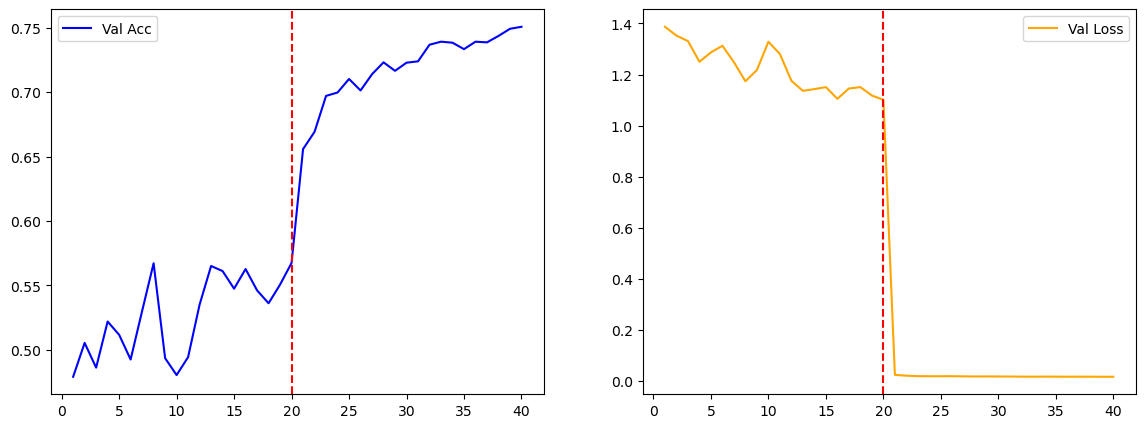

In [20]:
with open('training_history.pkl', 'rb') as f:
    h1 = pickle.load(f)
acc = h1['val_accuracy'] + history.history['val_accuracy']
loss = h1['val_loss'] + history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label = 'Val Acc')
plt.axvline(len(h1['val_accuracy']), color = 'r', linestyle = '--')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'orange', label = 'Val Loss')
plt.axvline(len(h1['val_loss']), color = 'r', linestyle = '--')
plt.legend()
plt.savefig('final_history.jpg')
plt.show()

In [ ]:
# 